In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torchvision.__version__

cuda:0


'0.7.0'

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


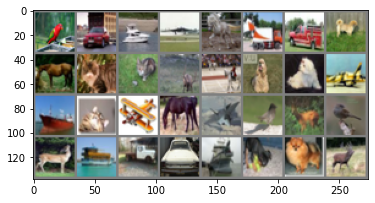

bird  car   ship  plane horse truck truck dog   horse cat   cat   deer  horse dog   dog   plane ship  cat   plane horse plane bird  deer  bird  deer  ship  truck car   ship  dog   dog   deer 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


net = Net()
net.to(device)


Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
softmax = nn.Softmax(dim=1)

In [6]:
acc_tracker=[]
loss_tracker=[]
total_train = 0

for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc = 0.0
    iter_inbatch = 0  # Iteration in batch

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        net.to(device)
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        # calcuate an objective loss
        loss = criterion(outputs, labels)

        # get probabilites of each label
        proba = softmax(outputs).cpu().detach().numpy()
        # get predicted label
        pred_labels = [np.argmax(i) for i in proba]
        pred_labels = np.array(pred_labels)


        # Calculated accuracy
        correct = 0
        accuracy = 0

        # allocate label to cpu
        gtlabels = labels.cpu().detach().numpy()

        for p ,g in zip(pred_labels,gtlabels):

            if p == g:
                correct+=1

        acc = 100 * (correct/len(gtlabels))

        # backprop and optmizer update weight
        loss.backward()
        optimizer.step()
        running_acc +=acc
        running_loss +=loss.item()
        iter_inbatch +=1


        # print("Training Epochs : {} , Loss : {} , Acc : {} ".format(epoch,(running_loss/iter_inbatch), (running_acc/iter_inbatch)))

    # get loss in current epoch
    train_loss = running_loss/iter_inbatch # calculate a mean loss (total loss / iteration)
    train_acc = running_acc/iter_inbatch
    print(f'Epoch {epoch} Training Loss: {train_loss} Accuracy: {train_acc}')
    loss_tracker.append(train_loss)
    acc_tracker.append(train_acc)

Epoch 0 Training Loss: 2.303708752377706 Accuracy: 9.86084452975048
Epoch 1 Training Loss: 2.3027791029661038 Accuracy: 9.79886436340371
Epoch 2 Training Loss: 2.3027208664443197 Accuracy: 10.008797184900832
Epoch 3 Training Loss: 2.302710727324336 Accuracy: 9.924824056301983
Epoch 4 Training Loss: 2.302722015521195 Accuracy: 9.828854766474729
Epoch 5 Training Loss: 2.3027518247078413 Accuracy: 9.776871401151631
Epoch 6 Training Loss: 2.3026890403859825 Accuracy: 9.86084452975048
Epoch 7 Training Loss: 2.302649174602994 Accuracy: 9.806861804222649
Epoch 8 Training Loss: 2.3025844202389414 Accuracy: 10.048784388995522
Epoch 9 Training Loss: 2.3025615918506666 Accuracy: 9.94081893793986
Epoch 10 Training Loss: 2.3024582377779734 Accuracy: 10.134756877799104
Epoch 11 Training Loss: 2.301807404784766 Accuracy: 11.040467050543826
Epoch 12 Training Loss: 2.2877845279085887 Accuracy: 14.61332373640435
Epoch 13 Training Loss: 2.0451360663312106 Accuracy: 21.307181701855406
Epoch 14 Training Lo

In [7]:
PATH = './40_epoch_32_batch_SGD_net.pth'
torch.save(net.state_dict(), PATH)

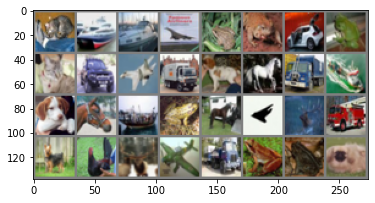

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
net = Net()
net.to(device)

net.load_state_dict(torch.load(PATH))
# outputs = net(images)

<All keys matched successfully>

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  ship  plane car   horse


In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 74 %


In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 79.1 %
Accuracy for class: car   is 87.3 %
Accuracy for class: bird  is 66.4 %
Accuracy for class: cat   is 51.0 %
Accuracy for class: deer  is 69.2 %
Accuracy for class: dog   is 59.5 %
Accuracy for class: frog  is 79.4 %
Accuracy for class: horse is 81.5 %
Accuracy for class: ship  is 88.9 %
Accuracy for class: truck is 78.8 %


In [13]:
import csv

csv_filename = "SDG_40_epochs_training_log.csv"
epochlist= [i for i in range(1, epoch+1) ]
with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["nepochs", "accuracy", "loss"])
    csv_writer.writerows(zip(epochlist, acc_tracker, loss_tracker))

print(f"Logbook exported to {csv_filename}")

Logbook exported to SDG_40_epochs_training_log.csv


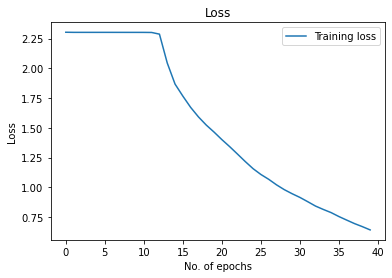

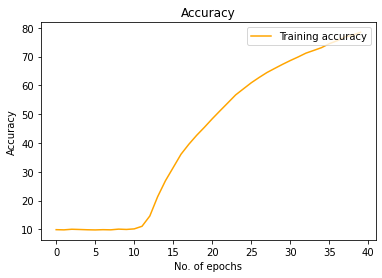

In [14]:
plt.plot(np.arange(0,40), loss_tracker, label='Training loss')
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(acc_tracker, label='Training accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()